## 🎓 Persona : Léa, jeune investisseuse étudiante

**Profil :**
- 👩 24 ans, diplômée de l'EM Lyon
- 💼 Première expérience professionnelle après 2 ans d'alternance
- 💰 Aide parentale pour le financement + épargne personnelle (~15 000 €)
- 🎯 Objectif : réaliser un **premier investissement locatif** dans une **ville étudiante dynamique**

---

### 💡 Objectif d'investissement
> Trouver le **meilleur investissement locatif étudiant** possible avec un **budget global de 200 000 €**,  
> en ciblant un **studio à Lille**, tout en comparant brièvement avec un **T1 à Angers ou Nancy**.

---

### 💰 Hypothèses financières
| Élément | Montant estimé |
|----------|----------------|
| Prix d'achat visé | 160 000 – 180 000 € |
| Apport personnel | 15 000 € |
| Prêt immobilier estimé | 180 000 € sur 20 ans |
| Budget total (frais inclus) | **≈ 200 000 €** |
| Objectif de rentabilité brute | **≥ 5 %** |

---

### 🏙️ Cibles principales
| Ville | Type de bien | Prix moyen au m² | Loyer moyen mensuel | Observations |
|-------|---------------|------------------|---------------------|---------------|
| **Lille** | Studio (20–25 m²) | ~4 500 €/m² | 550–600 € | Marché étudiant tendu, forte demande locative |
| **Angers** | T1 (25–30 m²) | ~3 200 €/m² | 450–500 € | Ville très dynamique, bonne rentabilité brute |
| **Nancy** | T1 (25–30 m²) | ~2 800 €/m² | 420–470 € | Marché abordable, bon rapport prix/rentabilité |

---

### 🔍 Besoins data de Léa
- Identifier **les quartiers les plus rentables** à Lille (ou dans des villes comparables)
- Comparer avec **la rentabilité moyenne en France**
- Analyser l'**évolution du prix au m² et des loyers étudiants** depuis 5 ans
- Calculer la **rentabilité locative brute et nette** par quartier
- Visualiser les **zones à forte concentration étudiante**
- Fournir une **recommandation finale : "où investir avec 200k€ ?"**
- Évaluer le **taux de vacance locative** par quartier pour anticiper les périodes creuses (notamment l'été où les étudiants quittent les logements)
- Analyser la **proximité des transports en commun** et des universités/grandes écoles pour identifier les zones les plus attractives pour les étudiants
- Estimer les **charges de copropriété moyennes** par type de bien et par quartier pour affiner le calcul de rentabilité nette
- Identifier les **opportunités de biens nécessitant des travaux** (décote à l'achat) pour maximiser la plus-value à long terme

---

### 🧭 Objectif du notebook
Créer un outil interactif permettant à Léa de :
1. Comparer la rentabilité d'un **studio à Lille** avec celle d'un **T1 à Angers ou Nancy**  
2. Explorer visuellement les **zones à potentiel locatif élevé**  
3. Obtenir une **recommandation automatique** en fonction de son budget et de ses préférences

## Import des bibliothèques ##

In [4]:
!python -m pip install seaborn


In [24]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
from unidecode import unidecode
import glob
import numpy as np


### 1e vision : Analyse générale en France ###

Etude du prix/m^2 par grandes villes etudiantes en France. filtre = appartement, surface de 0 à 45m^2



Partie Valentine

Filtrer le DVF avec les 20 plus grandes villes étudiantes de France


DVF encore optimisé pour garder : seulement les colonnes indispensables,les 20 grandes villes étudiantes,les appartements de 0 à 45 m²

In [5]:
# Liste des 23 villes étudiantes
villes = [
    "PARIS","LYON","LILLE","TOULOUSE","BORDEAUX","MARSEILLE","MONTPELLIER","RENNES","STRASBOURG",
    "NANTES","GRENOBLE","NANCY","NICE","ANGERS","ROUEN","CLERMONT-FERRAND","CAEN","DIJON","TOURS","REIMS",
    "AJACCIO","ANNECY","TOULON"
]

# Colonnes à conserver
colonnes_utiles = [
    "Date mutation",
    "Nature mutation",
    "Valeur fonciere",
    "Code postal",
    "Commune",
    "Type local",
    "Surface reelle bati"
]

# Liste pour stocker les données filtrées
data_filtree = []

print("🔄 Lecture et filtrage du fichier DVF...")

# Lecture du fichier par morceaux
chunks = pd.read_csv("valeursfoncieres-2024.txt", sep="|", low_memory=False, chunksize=100000)

for i, chunk in enumerate(chunks):
    # Filtrer les villes étudiantes
    filtre = chunk[chunk["Commune"].isin(villes)]
    
    # Ne garder que les appartements
    filtre = filtre[filtre["Type local"] == "Appartement"]
    
    # Ne garder que les ventes
    filtre = filtre[filtre["Nature mutation"] == "Vente"]
    
    # Conversion et filtrage de la surface
    filtre["Surface reelle bati"] = pd.to_numeric(filtre["Surface reelle bati"], errors="coerce")
    filtre = filtre[filtre["Surface reelle bati"].between(1, 45)]
    
    # Conversion des valeurs foncières
    filtre["Valeur fonciere"] = (
        filtre["Valeur fonciere"]
        .astype(str)
        .str.replace(",", ".")
        .str.replace(" ", "")
    )
    filtre["Valeur fonciere"] = pd.to_numeric(filtre["Valeur fonciere"], errors="coerce")
    
    # Supprimer les valeurs manquantes ou aberrantes
    filtre = filtre.dropna(subset=["Valeur fonciere", "Surface reelle bati"])
    filtre = filtre[filtre["Valeur fonciere"] > 0]
    
    # Sélection des colonnes utiles
    filtre = filtre[colonnes_utiles]
    
    # Ajouter à la liste
    if len(filtre) > 0:
        data_filtree.append(filtre)
    
    # Affichage de la progression
    if (i + 1) % 10 == 0:
        print(f"   ✓ Traité {(i + 1) * 100000:,} lignes...")

# Concaténer toutes les données filtrées
print("\n🔄 Consolidation des données...")
df = pd.concat(data_filtree, ignore_index=True)

# Calcul du prix au m²
df["Prix_m2"] = df["Valeur fonciere"] / df["Surface reelle bati"]

# Réorganisation des colonnes
df = df[[
    "Commune",
    "Code postal",
    "Type local",
    "Surface reelle bati",
    "Valeur fonciere",
    "Prix_m2",
    "Date mutation"
]]

# Export du fichier final
df.to_csv("dvf_appartements_23villes_0_45m2.csv", index=False)

# Résumé détaillé
print("\n" + "="*60)
print("✅ Traitement terminé !")
print("="*60)
print(f"📊 Lignes conservées : {len(df):,}")
print(f"🏙️  Nombre de villes : {df['Commune'].nunique()}")
print(f"💾 Fichier créé : dvf_appartements_23villes_0_45m2.csv")

print(f"\n📈 Répartition par ville :")
print("-" * 60)
repartition = df.groupby("Commune").size().sort_values(ascending=False)
for ville, count in repartition.items():
    print(f"   {ville:20s} : {count:>6,} transactions")

print(f"\n💰 Statistiques des prix au m² :")
print("-" * 60)
print(f"   Prix moyen    : {df['Prix_m2'].mean():,.0f} €/m²")
print(f"   Prix médian   : {df['Prix_m2'].median():,.0f} €/m²")
print(f"   Prix minimum  : {df['Prix_m2'].min():,.0f} €/m²")
print(f"   Prix maximum  : {df['Prix_m2'].max():,.0f} €/m²")

print("\n" + "="*60)

🔄 Lecture et filtrage du fichier DVF...
   ✓ Traité 1,000,000 lignes...
   ✓ Traité 2,000,000 lignes...
   ✓ Traité 3,000,000 lignes...

🔄 Consolidation des données...

✅ Traitement terminé !
📊 Lignes conservées : 22,095
🏙️  Nombre de villes : 18
💾 Fichier créé : dvf_appartements_23villes_0_45m2.csv

📈 Répartition par ville :
------------------------------------------------------------
   TOULOUSE             :  3,008 transactions
   NICE                 :  2,824 transactions
   MONTPELLIER          :  1,713 transactions
   NANTES               :  1,652 transactions
   LILLE                :  1,599 transactions
   BORDEAUX             :  1,559 transactions
   ROUEN                :  1,109 transactions
   DIJON                :  1,073 transactions
   RENNES               :  1,045 transactions
   TOULON               :    949 transactions
   ANGERS               :    877 transactions
   GRENOBLE             :    864 transactions
   REIMS                :    850 transactions
   NANCY     

filtrer les valeurs aberrantes 

In [10]:


# Lecture du fichier
df = pd.read_csv("dvf_appartements_23villes_0_45m2.csv", low_memory=False)

print("📊 Statistiques AVANT filtrage des valeurs aberrantes :")
print(f"Nombre de lignes : {len(df):,}")
print(f"\nPrix au m² :")
print(f"  - Minimum : {df['Prix_m2'].min():,.2f} €/m²")
print(f"  - Maximum : {df['Prix_m2'].max():,.2f} €/m²")
print(f"  - Moyenne : {df['Prix_m2'].mean():,.2f} €/m²")
print(f"  - Médiane : {df['Prix_m2'].median():,.2f} €/m²")

# Comptage des valeurs aberrantes AVANT filtrage
print(f"\n⚠️ Valeurs aberrantes détectées :")
tres_bas = len(df[df['Prix_m2'] < 1000])
tres_eleves = len(df[df['Prix_m2'] > 100000])
print(f"  - Prix < 1 000 €/m² : {tres_bas}")
print(f"  - Prix > 100 000 €/m² : {tres_eleves}")

# FILTRAGE DES VALEURS ABERRANTES
# Critères adaptés aux grandes villes étudiantes :
# - Minimum : 1 000 €/m² (cohérent avec le marché des grandes villes)
# - Maximum : 100 000 €/m² (seuil officiel DVF)

df_filtre = df[
    (df['Prix_m2'] >= 1000) & 
    (df['Prix_m2'] <= 100000)
].copy()

# Statistiques APRÈS filtrage
print("\n" + "="*70)
print("📊 Statistiques APRÈS filtrage des valeurs aberrantes :")
print("="*70)
print(f"Nombre de lignes conservées : {len(df_filtre):,}")
print(f"Nombre de lignes supprimées : {len(df) - len(df_filtre):,} ({100*(len(df)-len(df_filtre))/len(df):.2f}%)")

print(f"\nPrix au m² :")
print(f"  - Minimum : {df_filtre['Prix_m2'].min():,.2f} €/m²")
print(f"  - Maximum : {df_filtre['Prix_m2'].max():,.2f} €/m²")
print(f"  - Moyenne : {df_filtre['Prix_m2'].mean():,.2f} €/m²")
print(f"  - Médiane : {df_filtre['Prix_m2'].median():,.2f} €/m²")


# Export du fichier nettoyé
df_filtre.to_csv("dvf_appartements_23villes_0_45m2_nettoye.csv", index=False)

print("\n✅ Fichier nettoyé créé : dvf_appartements_23villes_0_45m2_nettoye.csv")

📊 Statistiques AVANT filtrage des valeurs aberrantes :
Nombre de lignes : 22,095

Prix au m² :
  - Minimum : 0.03 €/m²
  - Maximum : 1,555,555.56 €/m²
  - Moyenne : 27,485.89 €/m²
  - Médiane : 4,157.89 €/m²

⚠️ Valeurs aberrantes détectées :
  - Prix < 1 000 €/m² : 168
  - Prix > 100 000 €/m² : 658

📊 Statistiques APRÈS filtrage des valeurs aberrantes :
Nombre de lignes conservées : 21,269
Nombre de lignes supprimées : 826 (3.74%)

Prix au m² :
  - Minimum : 1,000.00 €/m²
  - Maximum : 100,000.00 €/m²
  - Moyenne : 7,032.60 €/m²
  - Médiane : 4,107.14 €/m²

✅ Fichier nettoyé créé : dvf_appartements_23villes_0_45m2_nettoye.csv


Script qui permet de calculer le prix moyen au m² achat par ville et sortir un petit classement automatique

📊 CLASSEMENT DES VILLES PAR PRIX MOYEN AU M²
   Appartements ≤ 45m² - Données DVF 2024

🏆 CLASSEMENT COMPLET (du plus cher au moins cher) :

 Rang     Commune  Nombre de ventes  Prix moyen €/m²  Prix min €/m²  Prix max €/m²
    1      ANGERS               870          12331.0         1200.0        87500.0
    2       LILLE              1591           9791.0         1071.0        93103.0
    3       REIMS               843           8206.0         1119.0        90909.0
    4       ROUEN              1097           8188.0         1000.0        92333.0
    5       NANCY               830           7945.0         1000.0        81579.0
    6      ANNECY               394           7710.0         1846.0        60917.0
    7    BORDEAUX              1529           7377.0         1016.0        72105.0
    8    TOULOUSE              2511           6911.0         1000.0       100000.0
    9       TOURS               835           6730.0         1200.0        89286.0
   10        NICE            

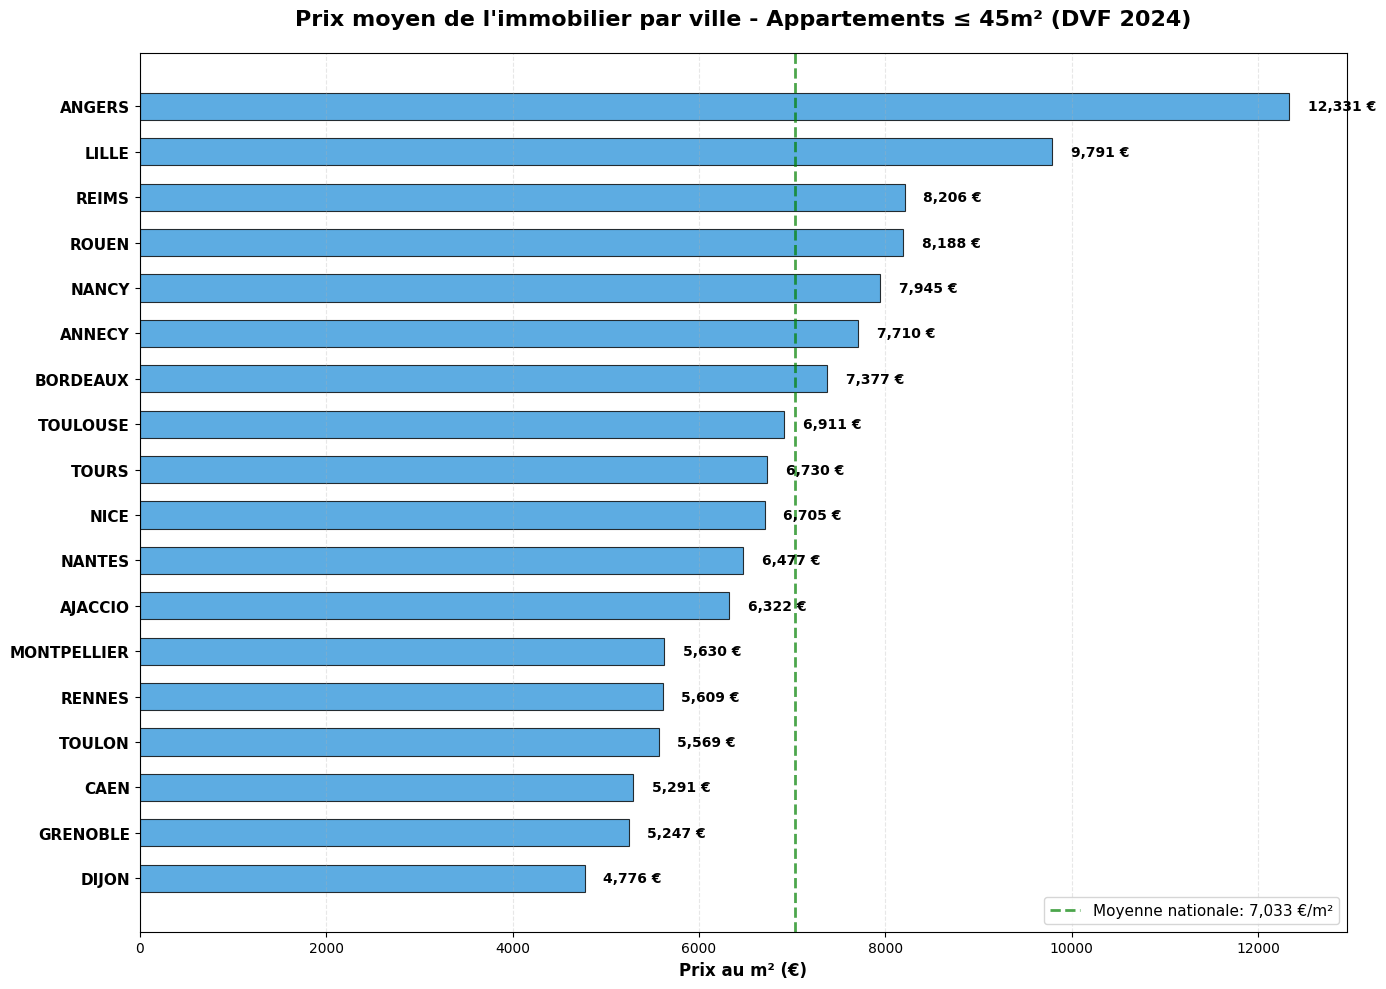

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Lecture du fichier nettoyé
df = pd.read_csv("dvf_appartements_23villes_0_45m2_nettoye.csv", low_memory=False)

print("="*80)
print("📊 CLASSEMENT DES VILLES PAR PRIX MOYEN AU M²")
print("   Appartements ≤ 45m² - Données DVF 2024")
print("="*80)

# Calcul des statistiques par ville
stats_villes = df.groupby("Commune").agg({
    'Prix_m2': ['count', 'mean', 'min', 'max']
}).round(0)

# Renommer les colonnes pour plus de clarté
stats_villes.columns = ['Nombre de ventes', 'Prix moyen €/m²', 'Prix min €/m²', 'Prix max €/m²']

# Trier par prix moyen décroissant
stats_villes = stats_villes.sort_values('Prix moyen €/m²', ascending=False)

# Réinitialiser l'index pour avoir la ville comme colonne
stats_villes = stats_villes.reset_index()

# Ajouter un rang
stats_villes.insert(0, 'Rang', range(1, len(stats_villes) + 1))

# Affichage du classement complet
print("\n🏆 CLASSEMENT COMPLET (du plus cher au moins cher) :\n")
print(stats_villes.to_string(index=False))

# Statistiques globales
print("\n" + "="*80)
print("📈 STATISTIQUES GLOBALES")
print("="*80)
print(f"Nombre total de ventes analysées : {len(df):,}")
print(f"Nombre de villes : {len(stats_villes)}")
print(f"\nPrix moyen national : {df['Prix_m2'].mean():,.0f} €/m²")

# Top 5 et Bottom 5
print("\n" + "="*80)
print("🥇 TOP 5 - VILLES LES PLUS CHÈRES")
print("="*80)
top5 = stats_villes.head(5)[['Rang', 'Commune', 'Prix moyen €/m²', 'Nombre de ventes']]
for idx, row in top5.iterrows():
    print(f"{row['Rang']}. {row['Commune']:20s} : {row['Prix moyen €/m²']:>7,.0f} €/m² - {row['Nombre de ventes']:.0f} ventes")

print("\n" + "="*80)
print("🎯 TOP 5 - VILLES LES MOINS CHÈRES")
print("="*80)
bottom5 = stats_villes.tail(5)[['Rang', 'Commune', 'Prix moyen €/m²', 'Nombre de ventes']]
for idx, row in bottom5.iterrows():
    print(f"{row['Rang']}. {row['Commune']:20s} : {row['Prix moyen €/m²']:>7,.0f} €/m² - {row['Nombre de ventes']:.0f} ventes")

# Export du classement en CSV
stats_villes.to_csv("classement_prix_m2_par_ville.csv", index=False)
print("\n✅ Classement exporté : classement_prix_m2_par_ville.csv")

# ==============================================================================
# GRAPHIQUE
# ==============================================================================

# Calcul des statistiques par ville pour le graphique
stats_villes_graph = df.groupby("Commune").agg({
    'Prix_m2': ['mean', 'count']
}).round(0)

stats_villes_graph.columns = ['Prix moyen €/m²', 'Nombre de ventes']
stats_villes_graph = stats_villes_graph.sort_values('Prix moyen €/m²', ascending=True)  # Tri croissant pour le graphique

# Création de la figure
fig, ax = plt.subplots(figsize=(14, 10))

# Création du graphique à barres horizontales
villes = stats_villes_graph.index
prix_moyens = stats_villes_graph['Prix moyen €/m²']

y_pos = range(len(villes))

# Barres pour prix moyen uniquement
bars = ax.barh(y_pos, prix_moyens, height=0.6, color='#3498db', alpha=0.8, edgecolor='black', linewidth=0.8)

# Ajout des valeurs sur les barres
for i, bar in enumerate(bars):
    ax.text(bar.get_width() + 200, bar.get_y() + bar.get_height()/2, 
            f'{int(prix_moyens.iloc[i]):,} €', 
            va='center', fontsize=10, fontweight='bold')

# Configuration des axes
ax.set_yticks(y_pos)
ax.set_yticklabels(villes, fontsize=11, fontweight='bold')
ax.set_xlabel('Prix au m² (€)', fontsize=12, fontweight='bold')
ax.set_title('Prix moyen de l\'immobilier par ville - Appartements ≤ 45m² (DVF 2024)', 
             fontsize=16, fontweight='bold', pad=20)

# Grille
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Ajout d'une ligne pour le prix moyen national
prix_moyen_national = df['Prix_m2'].mean()
ax.axvline(x=prix_moyen_national, color='green', linestyle='--', linewidth=2, 
           label=f'Moyenne nationale: {prix_moyen_national:,.0f} €/m²', alpha=0.7)
ax.legend(loc='lower right', fontsize=11)

plt.tight_layout()
plt.savefig('classement_prix_m2_villes.png', dpi=300, bbox_inches='tight')
print("\n✅ Graphique sauvegardé : classement_prix_m2_villes.png")
plt.show()

Partie Axel

In [ ]:

# ==============================================================================
# ÉTAPE 2 : TRAITER LES FICHIERS DE LOYERS (OBSERVATOIRE DES LOYERS)
# ==============================================================================

# Chemin vers le dossier contenant les fichiers de loyers
dossier_loyers = r"https://huggingface.co/datasets/analysedonneesfoncieresdata/analyse_fonciere_data/resolve/main/data_loyer.zip"

# Liste pour stocker les résultats
resultats_loyers = []

# Rechercher tous les fichiers CSV de loyers
fichiers_loyers = glob.glob(os.path.join(dossier_loyers, "Base_OP_*.csv"))

print(f"🔍 {len(fichiers_loyers)} fichiers de loyers trouvés\n")

if len(fichiers_loyers) == 0:
    print("❌ Aucun fichier trouvé. Vérifie le chemin du dossier.")
else:
    for fichier in fichiers_loyers:
        try:
            # Extraire le nom du fichier sans le chemin
            nom_fichier = os.path.basename(fichier)
            
            # Extraire le nom de la ville du fichier
            parties = nom_fichier.replace('.csv', '').split('_')
            code_ville = parties[3] if len(parties) > 3 else "INCONNU"
            nom_ville = parties[4].upper() if len(parties) > 4 else "INCONNU"
            
            # Charger le fichier avec le bon séparateur (point-virgule)
            df_loyer = pd.read_csv(fichier, encoding='cp1252', sep=';', low_memory=False)
            
            # Nettoyer les noms de colonnes (enlever les espaces)
            df_loyer.columns = df_loyer.columns.str.strip()
            
            # Convertir loyer_moyen en numérique (remplacer virgule par point et espaces)
            if 'loyer_moyen' in df_loyer.columns:
                df_loyer['loyer_moyen'] = (
                    df_loyer['loyer_moyen']
                    .astype(str)
                    .str.replace(',', '.')
                    .str.replace(' ', '')
                    .replace('', None)
                )
                df_loyer['loyer_moyen'] = pd.to_numeric(df_loyer['loyer_moyen'], errors='coerce')
            
            # Convertir surface_moyenne en numérique
            if 'surface_moyenne' in df_loyer.columns:
                df_loyer['surface_moyenne'] = pd.to_numeric(df_loyer['surface_moyenne'], errors='coerce')
            
            # Convertir nombre_observations en numérique
            if 'nombre_observations' in df_loyer.columns:
                df_loyer['nombre_observations'] = pd.to_numeric(df_loyer['nombre_observations'], errors='coerce')
            
            # FILTRER : Appartements avec petites surfaces (≤ 45m²)
            # On garde les 1P et 2P qui correspondent généralement à ≤ 45m²
            filtre = df_loyer[
                (
                    (df_loyer['Type_habitat'] == 'Appartement') |
                    (df_loyer['nombre_pieces_homogene'].isin(['Appart 1P', 'Appart 2P']))
                ) &
                (df_loyer['surface_moyenne'].notna()) &
                (df_loyer['surface_moyenne'] <= 45) &
                (df_loyer['loyer_moyen'].notna()) &
                (df_loyer['nombre_observations'].notna())
            ]
            
            if len(filtre) > 0:
                # Calculer le loyer moyen au m² pondéré par le nombre d'observations
                loyer_moyen_m2 = (
                    (filtre['loyer_moyen'] * filtre['nombre_observations']).sum() / 
                    filtre['nombre_observations'].sum()
                )
                
                # Stocker les résultats
                resultats_loyers.append({
                    'Ville': nom_ville,
                    'Code': code_ville,
                    'Loyer_moyen_m2': round(loyer_moyen_m2, 2),
                    'Nombre_observations': int(filtre['nombre_observations'].sum())
                })
                
                print(f"✅ {nom_ville:25s} : {loyer_moyen_m2:6.2f} €/m² ({int(filtre['nombre_observations'].sum()):,} obs)")
            else:
                print(f"⚠️  {nom_ville:25s} : Pas de données pour appartements ≤ 45m²")
        
        except Exception as e:
            print(f"❌ Erreur avec {nom_fichier}: {str(e)}")

    # Créer un DataFrame avec les résultats
    if len(resultats_loyers) > 0:
        df_loyers_villes = pd.DataFrame(resultats_loyers)
        
        # Trier par ville
        df_loyers_villes = df_loyers_villes.sort_values('Ville')
        
        # Afficher le récapitulatif
        print("\n" + "="*80)
        print("📊 RÉCAPITULATIF DES LOYERS PAR VILLE (Appartements ≤ 45m²)")
        print("="*80)
        print(df_loyers_villes.to_string(index=False))
        
        # Exporter en CSV
        df_loyers_villes.to_csv("loyers_moyens_par_ville.csv", index=False)
        print("\n✅ Fichier créé : loyers_moyens_par_ville.csv")
        
        # Statistiques globales
        print("\n" + "="*80)
        print("📈 STATISTIQUES GLOBALES")
        print("="*80)
        print(f"Nombre de villes analysées : {len(df_loyers_villes)}")
        print(f"Loyer moyen national : {df_loyers_villes['Loyer_moyen_m2'].mean():.2f} €/m²")
        print(f"Loyer médian national : {df_loyers_villes['Loyer_moyen_m2'].median():.2f} €/m²")
        print(f"Loyer minimum : {df_loyers_villes['Loyer_moyen_m2'].min():.2f} €/m²")
        print(f"   → {df_loyers_villes.loc[df_loyers_villes['Loyer_moyen_m2'].idxmin(), 'Ville']}")
        print(f"Loyer maximum : {df_loyers_villes['Loyer_moyen_m2'].max():.2f} €/m²")
        print(f"   → {df_loyers_villes.loc[df_loyers_villes['Loyer_moyen_m2'].idxmax(), 'Ville']}")
    else:
        print("\n❌ Aucune donnée exploitable trouvée dans les fichiers.")

NameError: name 'glob' is not defined

✅ Graphique sauvegardé : loyers_moyens_par_ville.png


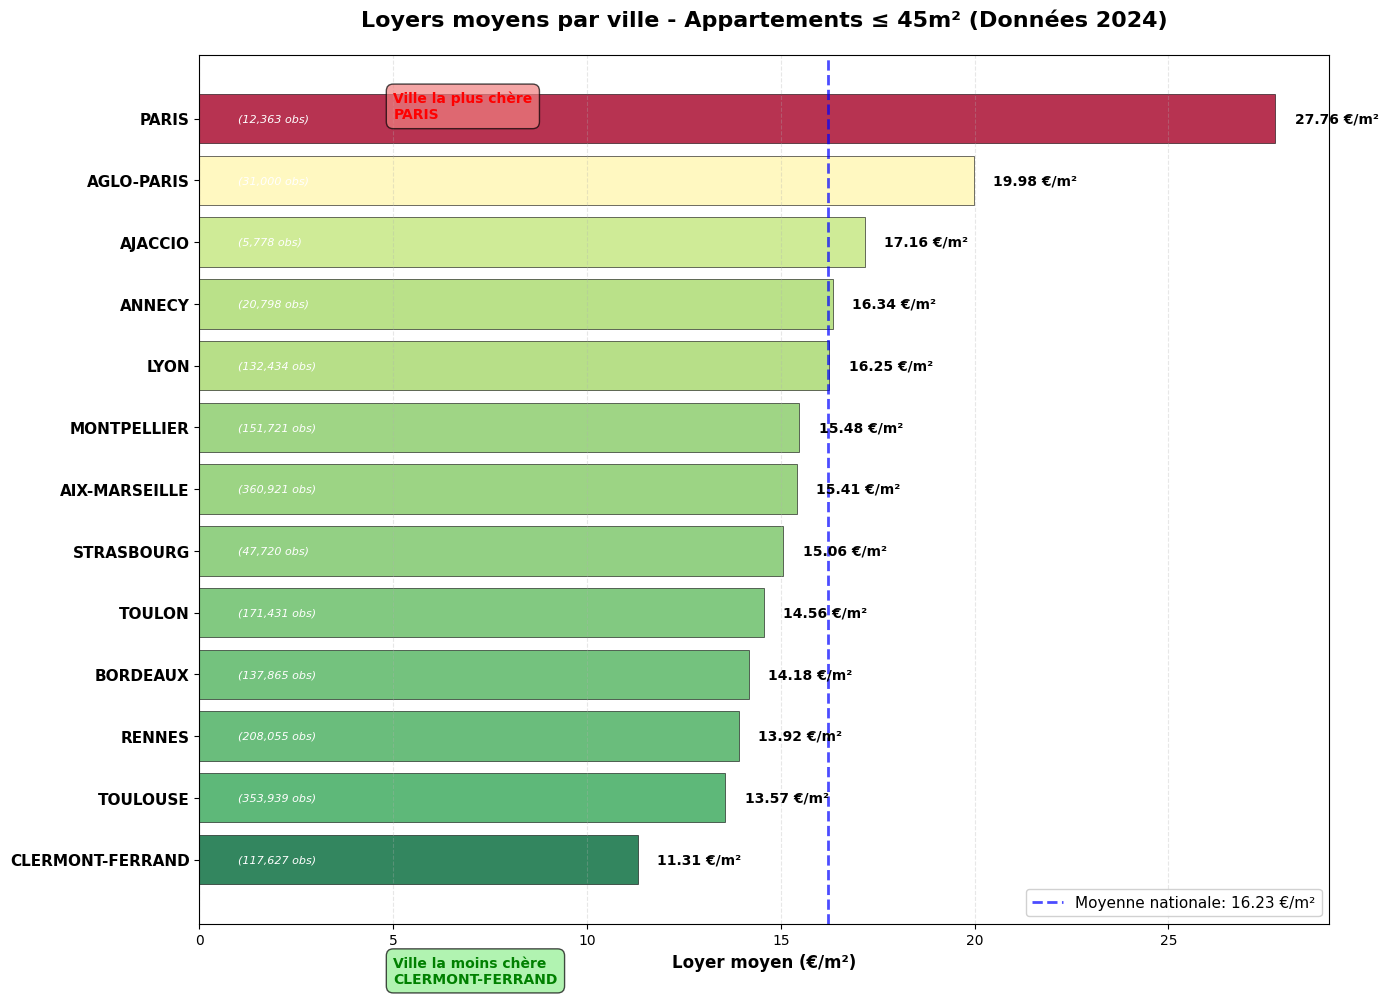

In [ ]:
# Lecture du fichier des loyers
df_loyers = pd.read_csv("loyers_moyens_par_ville.csv")

# Trier par loyer croissant pour le graphique
df_loyers = df_loyers.sort_values('Loyer_moyen_m2', ascending=True)

# Création de la figure
fig, ax = plt.subplots(figsize=(14, 10))

# Création du graphique à barres horizontales
villes = df_loyers['Ville']
loyers = df_loyers['Loyer_moyen_m2']
observations = df_loyers['Nombre_observations']

y_pos = range(len(villes))

# Barres avec dégradé de couleur selon le prix
colors = plt.cm.RdYlGn_r([(l - loyers.min()) / (loyers.max() - loyers.min()) for l in loyers])
bars = ax.barh(y_pos, loyers, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)

# Ajout des valeurs sur les barres
for i, (bar, loyer, obs) in enumerate(zip(bars, loyers, observations)):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{loyer:.2f} €/m²', 
            va='center', fontsize=10, fontweight='bold')
    # Ajout du nombre d'observations à gauche
    ax.text(1, bar.get_y() + bar.get_height()/2, 
            f'({obs:,} obs)', 
            va='center', ha='left', fontsize=8, color='white', style='italic')

# Configuration des axes
ax.set_yticks(y_pos)
ax.set_yticklabels(villes, fontsize=11, fontweight='bold')
ax.set_xlabel('Loyer moyen (€/m²)', fontsize=12, fontweight='bold')
ax.set_title('Loyers moyens par ville - Appartements ≤ 45m² (Données 2024)', 
             fontsize=16, fontweight='bold', pad=20)

# Ajout de la grille
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Ligne pour le loyer moyen national
loyer_moyen_national = df_loyers['Loyer_moyen_m2'].mean()
ax.axvline(x=loyer_moyen_national, color='blue', linestyle='--', linewidth=2, 
           label=f'Moyenne nationale: {loyer_moyen_national:.2f} €/m²', alpha=0.7)

# Légende
ax.legend(loc='lower right', fontsize=11, framealpha=0.9)

# Ajout d'annotations pour le min et max
min_ville = df_loyers.iloc[0]['Ville']
max_ville = df_loyers.iloc[-1]['Ville']
ax.annotate(f'Ville la moins chère\n{min_ville}', 
            xy=(df_loyers.iloc[0]['Loyer_moyen_m2'], 0), 
            xytext=(5, -2),
            fontsize=10, color='green', fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.7))
ax.annotate(f'Ville la plus chère\n{max_ville}', 
            xy=(df_loyers.iloc[-1]['Loyer_moyen_m2'], len(villes)-1), 
            xytext=(5, len(villes)-1),
            fontsize=10, color='red', fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightcoral', alpha=0.7))

plt.tight_layout()
plt.show()

Objectif : calculer la rentabilité locative brute moyenne

La rentabilité locative brute se calcule ainsi :

Rentabilite brute (%) = (Loyer annuel/Prix d'achat)x100

Pour chaque ville : Rentabilité = (Loyer_moyen x 12)/(Prix_moyen_m^2 x Surface moyenne)



In [22]:

# Lecture du fichier de rentabilité
df_rentabilite = pd.read_csv("rentabilite_locative_par_ville.csv")

# Calcul du loyer annuel au m²
df_rentabilite['Loyer_annuel_m2'] = (df_rentabilite['Loyer_moyen_m2'] * 12).round(2)

# Trier par rentabilité décroissante
df_rentabilite = df_rentabilite.sort_values('Rentabilite_brute_%', ascending=False)

# Réinitialiser l'index pour avoir un classement de 1 à N
df_rentabilite = df_rentabilite.reset_index(drop=True)
df_rentabilite.insert(0, 'Rang', range(1, len(df_rentabilite) + 1))

print("="*120)
print("💰 CLASSEMENT COMPLET DES VILLES PAR RENTABILITÉ BRUTE")
print("   Appartements ≤ 45m² - Données 2024")
print("="*120)
print()

# Affichage formaté avec toutes les colonnes demandées
print(f"{'Rang':<5} {'Ville':<20} {'Rent. %':<10} {'Loyer/m²':<12} {'Loyer annuel/m²':<18} {'Prix achat/m²':<15}")
print("-" * 120)

for idx, row in df_rentabilite.iterrows():
    print(f"{row['Rang']:<5} "
          f"{row['Commune']:<20} "
          f"{row['Rentabilite_brute_%']:>6.2f}%   "
          f"{row['Loyer_moyen_m2']:>8.2f} €   "
          f"{row['Loyer_annuel_m2']:>12.2f} €      "
          f"{row['Prix_achat_moyen_m2']:>10,.2f} €")

print("="*120)

# Statistiques récapitulatives
print("\n📊 STATISTIQUES RÉCAPITULATIVES")
print("="*120)
print(f"{'Métrique':<40} {'Minimum':<20} {'Moyenne':<20} {'Maximum':<20}")
print("-" * 120)
print(f"{'Rentabilité brute (%)':<40} "
      f"{df_rentabilite['Rentabilite_brute_%'].min():>6.2f}%          "
      f"{df_rentabilite['Rentabilite_brute_%'].mean():>6.2f}%          "
      f"{df_rentabilite['Rentabilite_brute_%'].max():>6.2f}%")
print(f"{'Loyer mensuel (€/m²)':<40} "
      f"{df_rentabilite['Loyer_moyen_m2'].min():>8.2f} €        "
      f"{df_rentabilite['Loyer_moyen_m2'].mean():>8.2f} €        "
      f"{df_rentabilite['Loyer_moyen_m2'].max():>8.2f} €")
print(f"{'Loyer annuel (€/m²)':<40} "
      f"{df_rentabilite['Loyer_annuel_m2'].min():>8.2f} €        "
      f"{df_rentabilite['Loyer_annuel_m2'].mean():>8.2f} €        "
      f"{df_rentabilite['Loyer_annuel_m2'].max():>8.2f} €")
print(f"{'Prix achat (€/m²)':<40} "
      f"{df_rentabilite['Prix_achat_moyen_m2'].min():>8.2f} €        "
      f"{df_rentabilite['Prix_achat_moyen_m2'].mean():>8.2f} €        "
      f"{df_rentabilite['Prix_achat_moyen_m2'].max():>8.2f} €")
print("="*120)

# TOP 3 et BOTTOM 3
print("\n🏆 TOP 3 - VILLES LES PLUS RENTABLES")
print("="*120)
for idx, row in df_rentabilite.head(3).iterrows():
    print(f"\n{row['Rang']}. {row['Commune']}")
    print(f"   💰 Rentabilité brute    : {row['Rentabilite_brute_%']:.2f}%")
    print(f"   📅 Loyer mensuel/m²     : {row['Loyer_moyen_m2']:.2f} €")
    print(f"   📅 Loyer annuel/m²      : {row['Loyer_annuel_m2']:.2f} €")
    print(f"   🏠 Prix achat/m²        : {row['Prix_achat_moyen_m2']:,.2f} €")
    print(f"   📊 Nombre de ventes     : {int(row['Nombre_ventes']):,}")

print("\n\n📉 TOP 3 - VILLES LES MOINS RENTABLES")
print("="*120)
for idx, row in df_rentabilite.tail(3).iloc[::-1].iterrows():
    print(f"\n{row['Rang']}. {row['Commune']}")
    print(f"   💰 Rentabilité brute    : {row['Rentabilite_brute_%']:.2f}%")
    print(f"   📅 Loyer mensuel/m²     : {row['Loyer_moyen_m2']:.2f} €")
    print(f"   📅 Loyer annuel/m²      : {row['Loyer_annuel_m2']:.2f} €")
    print(f"   🏠 Prix achat/m²        : {row['Prix_achat_moyen_m2']:,.2f} €")
    print(f"   📊 Nombre de ventes     : {int(row['Nombre_ventes']):,}")

print("\n" + "="*120)

💰 CLASSEMENT COMPLET DES VILLES PAR RENTABILITÉ BRUTE
   Appartements ≤ 45m² - Données 2024

Rang  Ville                Rent. %    Loyer/m²     Loyer annuel/m²    Prix achat/m²  
------------------------------------------------------------------------------------------------------------------------
1     MONTPELLIER            3.30%      15.48 €         185.76 €        5,629.62 €
2     AJACCIO                3.26%      17.16 €         205.92 €        6,322.45 €
3     TOULON                 3.14%      14.56 €         174.72 €        5,569.40 €
4     RENNES                 2.98%      13.92 €         167.04 €        5,608.53 €
5     ANNECY                 2.54%      16.34 €         196.08 €        7,710.38 €
6     TOULOUSE               2.36%      13.57 €         162.84 €        6,911.28 €
7     BORDEAUX               2.31%      14.18 €         170.16 €        7,376.94 €

📊 STATISTIQUES RÉCAPITULATIVES
Métrique                                 Minimum              Moyenne              Maxi

✅ Graphique sauvegardé : analyse_rentabilite_finale.png


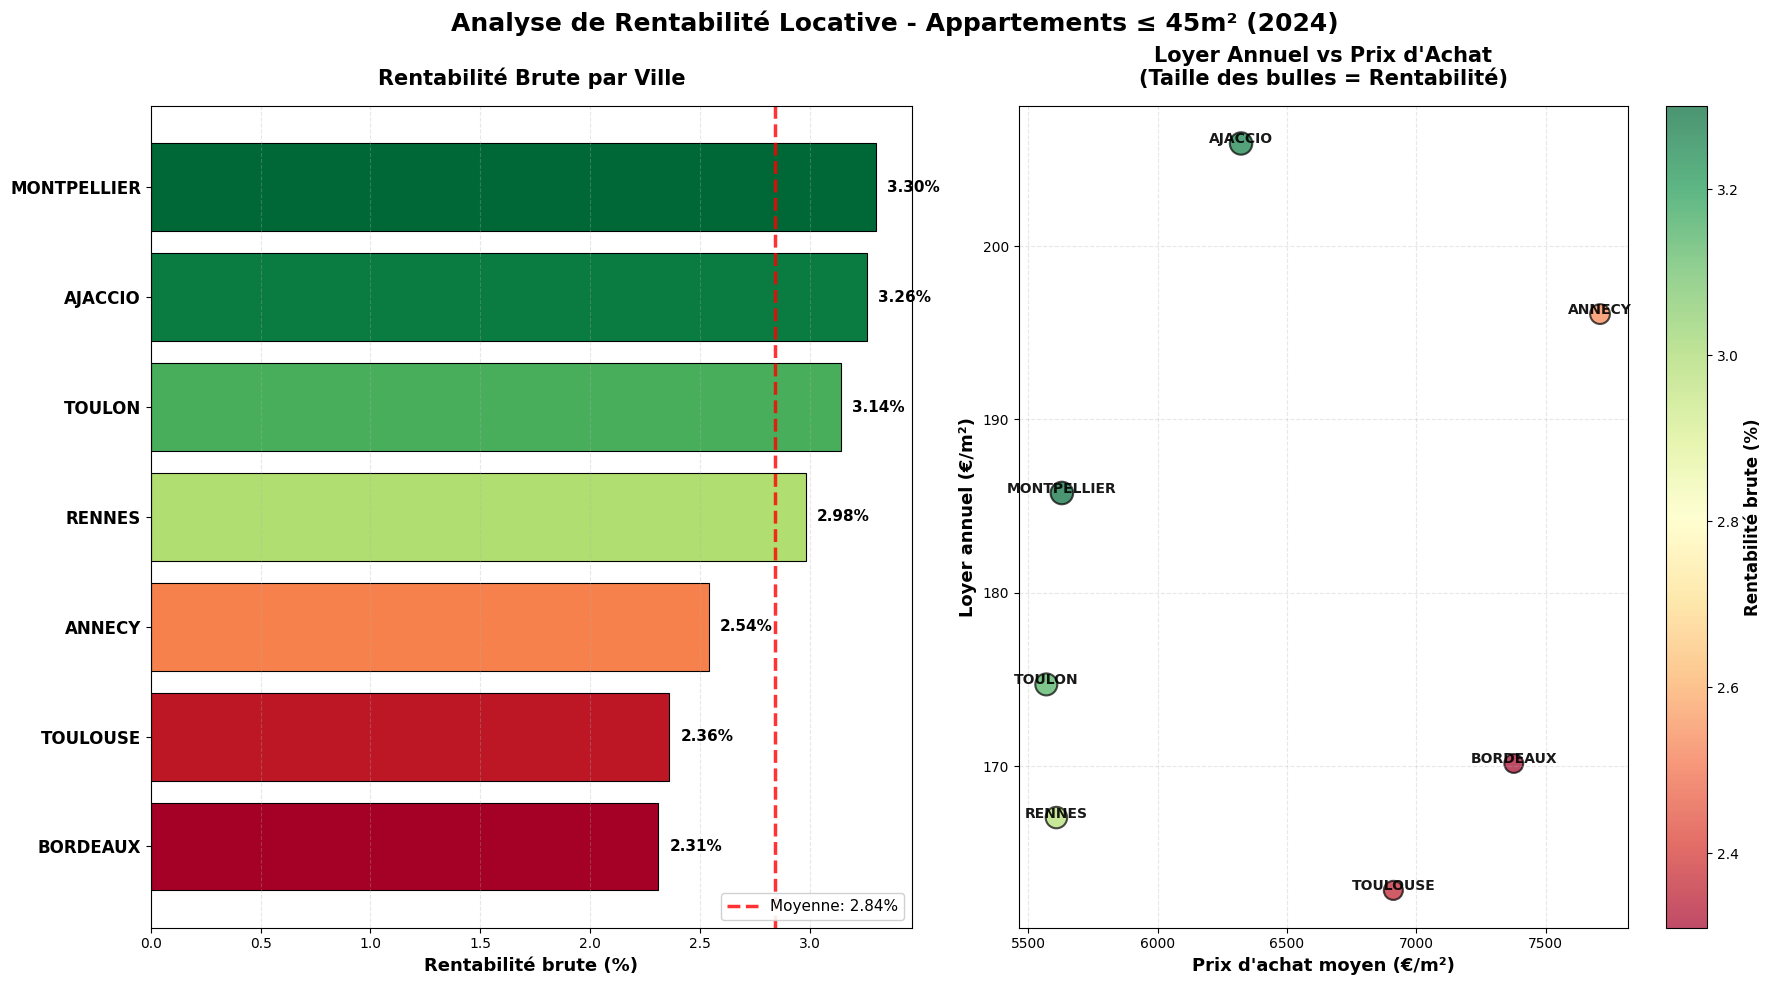

In [28]:
i# Lecture du fichier de rentabilité
df_rentabilite = pd.read_csv("rentabilite_locative_par_ville.csv")

# Calcul du loyer annuel au m²
df_rentabilite['Loyer_annuel_m2'] = (df_rentabilite['Loyer_moyen_m2'] * 12).round(2)

# Trier par rentabilité décroissante
df_rentabilite = df_rentabilite.sort_values('Rentabilite_brute_%', ascending=True)  # Croissant pour le graphique

# ==============================================================================
# GRAPHIQUE : RENTABILITÉ LOCATIVE (2 graphiques côte à côte)
# ==============================================================================

fig, axes = plt.subplots(1, 2, figsize=(18, 10))
fig.suptitle('Analyse de Rentabilité Locative - Appartements ≤ 45m² (2024)', 
             fontsize=18, fontweight='bold', y=0.98)

# --- GRAPHIQUE 1 : Rentabilité brute par ville ---
ax1 = axes[0]
villes = df_rentabilite['Commune']
rentabilite = df_rentabilite['Rentabilite_brute_%']

colors = plt.cm.RdYlGn([(r - rentabilite.min()) / (rentabilite.max() - rentabilite.min()) for r in rentabilite])
bars1 = ax1.barh(range(len(villes)), rentabilite, color=colors, edgecolor='black', linewidth=0.8)

# Ajouter les valeurs sur les barres
for i, (bar, val) in enumerate(zip(bars1, rentabilite)):
    ax1.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2, 
            f'{val:.2f}%', va='center', fontsize=11, fontweight='bold')

ax1.set_yticks(range(len(villes)))
ax1.set_yticklabels(villes, fontsize=12, fontweight='bold')
ax1.set_xlabel('Rentabilité brute (%)', fontsize=13, fontweight='bold')
ax1.set_title('Rentabilité Brute par Ville', fontsize=15, fontweight='bold', pad=15)
ax1.grid(axis='x', alpha=0.3, linestyle='--')
ax1.axvline(x=rentabilite.mean(), color='red', linestyle='--', linewidth=2.5, alpha=0.8, 
           label=f'Moyenne: {rentabilite.mean():.2f}%')
ax1.legend(loc='lower right', fontsize=11, framealpha=0.9)

# --- GRAPHIQUE 2 : Loyer ANNUEL vs Prix d'achat (Scatter) ---
ax2 = axes[1]
scatter = ax2.scatter(df_rentabilite['Prix_achat_moyen_m2'], 
                     df_rentabilite['Loyer_annuel_m2'],  # LOYER ANNUEL
                     s=df_rentabilite['Rentabilite_brute_%']*80,  # Taille selon rentabilité
                     c=df_rentabilite['Rentabilite_brute_%'],
                     cmap='RdYlGn',
                     alpha=0.7,
                     edgecolors='black',
                     linewidth=1.5)

# Ajouter les noms de villes
for idx, row in df_rentabilite.iterrows():
    ax2.annotate(row['Commune'], 
                (row['Prix_achat_moyen_m2'], row['Loyer_annuel_m2']),
                fontsize=10, ha='center', fontweight='bold', alpha=0.9)

ax2.set_xlabel('Prix d\'achat moyen (€/m²)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Loyer annuel (€/m²)', fontsize=13, fontweight='bold')
ax2.set_title('Loyer Annuel vs Prix d\'Achat\n(Taille des bulles = Rentabilité)', 
             fontsize=15, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, linestyle='--')

# Colorbar
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Rentabilité brute (%)', fontsize=12, fontweight='bold')
cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.savefig('analyse_rentabilite_finale.png', dpi=300, bbox_inches='tight')
print("✅ Graphique sauvegardé : analyse_rentabilite_finale.png")
plt.show()